<a href="https://colab.research.google.com/github/adeiltonmsantos/prepackaged-simulations/blob/main/prepackaged_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

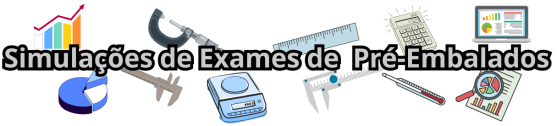




<p>
Esta aplicação se destina a IPEM's para avaliar as probabilidades de reprovação de produtos em todos os tamanhos de amostras do Regulamento Técnico em vigor.
</p>

<p>
Em algumas ocasiões, mercadorias pré-embaladas são aprovadas em amostras menores com valores de média e/ou número de unidades com erro individual muito próximos do limite.
</p>

<p>
Com esta aplicação você pode fazer o upload do laudo de exame da mercadoria em questão. Em seguida os dados das medições são extraídos e por meio de <strong>Simulações de Monte Carlo</strong> são estimadas as <strong>probabilidade de reprovação com todos os tamanhos de amostra do Regulamento Téncico em vigor (13, 20, 32 e 80 unidades)</strong>
</p>

<p>
Dessa forma, pode-se estimar se a mesma mercadoria poderia ser aprovada ou não em uma amostra maior, visto que os critérios de aprovação são mais rígidos em amostras maiores
</p>

<p>
A aplicação só não realiza as estimativas se os valores das medições do laudo uploaded não seguir distribuição de probabilidade normal
</p>




arrow.gif
  <span>&nbsp;</span>Clique no botão PLAY <span>play.png</span> abaixo para carregar as bibliotecas da aplicação

In [10]:
# @title
!pip install -q pdfplumber tensorflow
import pandas as pd
import pdfplumber as pdfp
import os
import numpy as np
import math
import time
from IPython.display import clear_output, HTML
from google.colab import files
import datetime as dt
from scipy import stats
clear_output()


##############################################################################
# Classe Splash

class Splash():
  """
  Splash()

  Classe para exibir pequenos splashs
  """

  def __init__(self):
    self.align = 'center'
    self.width = 200

    self.css_info = """
      border: 1px solid black; background-color: #ffff80; text-align: {};
      width: {}px; padding: 8px'
    """

    self.css_fail = """
      border: 1px solid black; background-color: red; color:white;
      font-size: 13pt; text-align: {}; width: {}px; padding: 8px
    """

    self.css_sucess = """
      border: 1px solid black; background-color: #00ff99; text-align: {};
      width: {}px; padding: 8px;
    """

    self.css = """
      border: 1px solid black; text-align: {}; width: {}px; padding: 8px
    """

    self.div = '<div style="{}; font-size: {}"><div style="padding: 12px">{}</div></div>'

  def renderSplash(self, msg, tipo='sucess', delay=0, width=200, align='center', font_size=13):
    """
    renderSplash(msg, tipo='sucess', delay=3, width=200, align='center', font_size=13)

    Método que renderiza um splash. Os parâmetros são:
    - msg: string com a mensagem
    - tipo: pode ser 'sucess' (padrão), 'info' ou 'fail'
    - delay: tempo em que o splash fica ativo. Após este tempo o splash é
             apagado. Se for omitido, o splash não se apaga
    - width: largura em px do splash
    - align: alinhamento do texto. Pode ser 'left', 'center', 'right' ou 'justify'
    - font_size: tamanho da fonte do texto. Padrão: 13px
    """

    clear_output()

    match tipo:
      case 'fail':
        self.css_fail = self.css_fail
        css = self.css_fail.format(align, width)
      case 'sucess':
        css = self.css_sucess.format(align, width)
      case 'info':
        css = self.css_info.format(align, width)
      case _:
        css = self.css.format(align, width)

    display(HTML(self.div.format(css, font_size, msg)))

    if delay > 0:
      time.sleep(delay)
      clear_output()



##############################################################################
# Classe Handler

class Handler():

  def __init__(self):
    # Raw data
    self.raw_data = None

    # List with measurements values
    self.list_measurements = None

    # DataFrame with measurements values
    self.df_measurements = None

    # Kind of exam
    self.kind_exam = None

    # Product name
    self.product_name = None

    # Qn (Nominal content, without unit)
    self.qn = None

    # Unit of Qn (unit of measurement)
    self.unit_qn = None

    # Qn for simulation (just numeric value). Its Qn converted to the same unit
    # of the measurements
    self.qn_normalized = None

    # Unit of measurements
    self.unit_qn_measurement = None

    # Average of sample report
    self.sample_avg = None

    # Standard deviation of sample report
    self.sample_std = None

    # Size of sample
    self.sample_size = None

    # Data to dataframe of statistics for simulations
    statistics = {
        'ind': [0, 0 ,0 ,0],
        'avg': [0, 0 ,0 ,0],
        'i_a': [0, 0 ,0 ,0],
    }

    # Dataframe with statistics for simulations
    self.df_statistics = pd.DataFrame(statistics, index=[13, 20, 32, 80])

    # Total of simulations per sample size
    self.cicles_per_sample_size = 10000

    # Duration of process
    self.total_time = 0

    # Values of k factor for average criteria and c for individual criteria
    k_c = {
        'k': [0.847, 0.640, 0.485, 0.295],
        'c': [1, 1, 2, 5]
    }

    # Values of T table for mass and volume units
    t_m_v = {
          'qn_i': [0, 50, 100, 200, 300, 500, 1000, 10000, 15000],
          'qn_f': [50, 100, 200, 300, 500, 1000, 10000, 15000, 1000000],
          'perc_qn': [0.09, 0, 0.045, 0, 0.03, 0, 0.015, 0, 0.01],
          'vlr_qn': [0, 4.5, 0, 9, 0, 15, 0, 150, 0]
    }

    # Dataframe with T values in function of Qn values in mass and volume units
    self.df_t_m_v = pd.DataFrame(t_m_v)

    # Values of T table for units number
    t_un = {
        'qn_i': [0, 31, 101, 201, 301],
        'qn_f': [30, 100, 200, 300, 1000000],
        'T': [0, 1, 2, 3, 0.01]
    }

    # Dataframe with T values in function of Qn values in number of units
    self.df_t_un = pd.DataFrame(t_un)


    # DataFrame with k factor for average criteria and c for individual criteria
    self.df_k_c = pd.DataFrame(k_c, index=[13, 20, 32, 80])

    # Values for conversion among mass unit values
    mass_conv = {
        'kg': [0.001, 1],
        'g': [1, 1000]
    }

    # DataFrame with conversion between mass units
    self.df_mass_conv = pd.DataFrame(mass_conv, index=['g', 'kg'])

    # Values for conversion among volume unit values
    vol_conv = {
        'L': [0.001, 1],
        'mL': [1, 1000]
    }

    # DataFrame with conversion between volume units
    self.df_volume_conv = pd.DataFrame(vol_conv, index=['mL', 'L'])

    length_conv = {
        'm': [0.001, 100, 1],
        'cm': [0.1, 1, 100],
        'mm': [1, 10, 1000]
    }

    # DataFrame with conversion betweeen length units
    self.df_length_conv = pd.DataFrame(length_conv, index=['mm', 'cm', 'm'])



  def extractData(self, filename):
    """
    extractData(filename)

    Method for extracting measurement data from a PDF examination report, given
    the filename url. If the PDF contains more than one report or infraction
    notice, it only extracts measurements from the first report in the document.
    Uses the 'pdfplumber' library, which must be previously imported with the
    alias 'pdfp'
    """
    content = pdfp.open(filename)

    # Extracting pages
    pages =content.pages

    # Extracting tables from all pages
    tables = []
    for pg in pages:
      tables.extend(pg.extract_tables()[0])

    self.raw_data = tables

    # Filling list with measurement values ​​only
    measurements = []
    unid = None
    kind = None
    n = 0

    # Flag to indicate that data product was not found yet. Usefull for report
    # with more then one page
    prod_data_not_found = True

    # Flag to indicate that Qn was not found yet
    qn_not_found = True

    for line in tables:

      # Storing string with the value of the nominal content unit
      if prod_data_not_found and str(line[0]).startswith('Produto'):
        self.unit_qn = line[0]

        # Spliting string in line[0]. First element contain product name
        lst_line = line[0].split('Código')

        # Spliting first element of lst_line
        lst_str = lst_line[0].split('Produto:')

        # Storing product name
        self.product_name = lst_str[1].strip()

        # Setting flag not to search for produtc data
        prod_data_not_found = False

      # Identifying size of sample
      if str(line[0]).startswith('Termo de Coleta'):
        for item in line:
          if str(item).startswith('Faixa do Lote'):
            self.sample_size = int(item.split('\n')[1].split(' ')[1])

      # Identifying exam type
      try:
        if qn_not_found and str(line[0]).startswith('Tipo de Embal'):
          qn_not_found = False
          item = [x for x in line if 'valor mín' in str(x).lower()]
          lista = item[0].split('\n')
          unid_lista = lista[1].split(' ')
          unid = unid_lista[len(unid_lista) - 1]
          unid_last_char = unid[-1]
          match unid_last_char:
            case 'g':
              kind = 'mass'
              self.unit_measurement = 'g'
              str_unit_qn = self.unit_qn
            case 'L':
              kind = 'volume'
              self.unit_measurement = 'mL'
              lst_unit_qn = self.unit_qn.split(' ')
              str_unit_qn = self.unit_qn
            case 'm':
              kind = 'length'
              self.unit_measurement = unid[len(unid)-2:]
              str_unit_qn = self.unit_qn
            case '.':
              kind = 'units'
              self.unit_measurement = 'unidades'

          if kind == 'units':
              str_qn = str(self.unit_qn.split('Unidades')[0].split(':')[-1]).strip()
              self.qn = int(str_qn)
              self.unit_qn = 'unidades'
          else:
              lst_unit_qn = str_unit_qn.split(' Massa Específica')
              lst_unit_qn = lst_unit_qn[0].split(' ')
              self.unit_qn = lst_unit_qn[len(lst_unit_qn) - 1]
              self.qn = float(lst_unit_qn[len(lst_unit_qn) - 2])
              # Storing kind of exam
        self.kind_exam = kind
      except Exception:
        pass

      # Identifying measurements
      try:
        array_values = line[0].split()
        if array_values[0].isdigit() and int(array_values[0]) > n:
          n += 1

          match kind:
            case 'mass':
              if len(array_values) > 1:
                vlr = str(array_values[3]).replace(',', '.')
                measurements.append(float(vlr))
            case 'volume':
              if len(array_values) > 1:
                vlr = str(array_values[3]).replace(',', '.')
                measurements.append(float(vlr))
            case 'length':
              if len(array_values) > 1:
                vlr = str(array_values[1]).replace(',', '.')
                measurements.append(float(vlr))
            case 'units':
              if str(line[1]).isdigit():
                measurements.append(int(line[1]))
      except Exception:
        pass

    self.list_measurements = measurements


    # Converting measurement data to dataframe
    self.df_measurements = pd.Series(self.list_measurements)

    # Calculating average and standard deviation
    self.sample_avg = self.df_measurements.mean()
    self.sample_std = self.df_measurements.std()

    # Deleting uploaded file
    os.remove(f'/content/{filename}')

  def sampleAdheresNormalDistribuition(self):
    """
    sampleAdheresNormalDistribuition()

    Tests if measurements extracted from exam report in PDF adheres to normal
    distribuition. Uses Shapiro-Wilk test for samples  up to size 32. Above that,
    uses KS test. Returns True if the sample adheres to normal distribuition.
    """

    try:
      n = len(self.df_measurements)
    except Exception:
      # Raise an Exception object with the desired message
      raise Exception('Ainda não foram extraídos dados de nenhum laudo')

    if n and n <= 32:
      # Running Shapiro-Wilk test
      shapiro_test = stats.shapiro(self.df_measurements)
      p_value = shapiro_test.pvalue
      # Return True if p-value is greater than significance level (e.g., 0.05).
      print(f'Shapiro-Wilk p-value: {p_value}')
      return p_value > 0.05
    elif n and n > 32:
      # Running KS test
      ks_test = stats.kstest(self.df_measurements, 'norm', args=(self.sample_avg, self.sample_std))
      p_value = ks_test.pvalue
      print(f'KS p-value: {p_value}')
      return p_value > 0.05



  def getDataFrameRandomSample(self, sample_size):
    """
    getDataFrameRandomSample(sample_size)

    Generate a random sample with normal distribution using self.sample_avg and
    self.sample_std as parameters. Return the values of the random sample in a
    DataFrame.
    """

    # Generating sample of size 'sample_size' with normal distribution from
    # the average and standard deviation extracted from the PDF (self.sampl_avg
    # and self.sample_std)
    sample = np.random.normal(self.sample_avg, self.sample_std, sample_size)
    return pd.DataFrame(sample, columns=['Qef'])


  def normalizeQn(self):
    """
    normalizeQn()

    Convert value of Qn from its current unit to the same unit of the measurements.

    """

    match self.kind_exam:
      case 'mass':
        self.qn_normalized = self.qn * float(self.df_mass_conv.loc[self.unit_qn, self.unit_measurement])
      case 'volume':
        self.qn_normalized = self.qn * float(self.df_volume_conv.loc[self.unit_qn, self.unit_measurement])
      case 'length':
        self.qn_normalized = self.qn * float(self.df_length_conv.loc[self.unit_qn, self.unit_measurement])
      case 'units':
        self.qn_normalized = self.qn


  def avgCriteriaAproved(self, df_sample):
    """
    avgCriteriaAproved(df_sample)

    Evaluate if the sample in dataframe (df_sample) is or not reproved in the
    average criteria. Return True if the sample is aproved.
    """

    # Converting unit of Qn to the same unti of measurements
    self.normalizeQn()

    # Size of sample
    n = self.sample_size

    # Converting Qn to the same unit of measurements
    qn = self.qn_normalized

    # Determining the minimum average and effective average
    if self.kind_exam == 'units':
      avg_min = self.qn_normalized
      avg_efc = math.ceil(df_sample.mean().item())
    else:
      avg_min = self.qn_normalized - (self.df_k_c.loc[n, 'k'] * self.sample_std)
      avg_efc = df_sample.mean().item()

    # Return result
    if avg_efc >= avg_min:
      return True
    else:
      return False


  def indCriteriaAproved(self, df_sample):
    """
    indCriteriaAproved(df_sample, kind_exam)

    Evaluate if the sample is or not reproved in the individual criteria. Return
    True if the sample is aproved.
    """

    # Converting unit of Qn to the same unti of measurements
    self.normalizeQn()

    # Getting Qn value with the same measurements unit
    qn = self.qn_normalized

    # Getting value of c
    c = self.df_k_c.loc[self.sample_size, 'c'].item()

    match self.kind_exam:
      # Qn in number of units
      case 'units':
        df_T_values = self.df_t_un.query('qn_i <= @qn < qn_f') # Returns a Pandas Series
        T = df_T_values['T'].item()
        if T == 0.01:
          min_value_ind = qn * (1 - T)
        else:
          min_value_ind = qn - T

      # Qn in length unit
      case 'length':
        min_value_ind = qn * 0.98

      # Qn in mass or volume unit
      case _:
        df_T_values = self.df_t_m_v.query('qn_i <= @qn < qn_f') # Returns a Pandas Series
        T_perc = df_T_values['perc_qn'].item()
        T_value = df_T_values['vlr_qn'].item()
        min_value_ind = qn * (1 - T_perc) - T_value

    total = df_sample.query('Qef < @min_value_ind')
    return len(total) <= c


  def simulate(self):
    """
    simulate()

    Performs 50,000 simulations of samples of 13, 20, 32, and 80 units, and with each
    set of 50,000 simulations, determines:
    -
    """

    # List with sample sizes
    sample_sizes = [13, 20, 32, 80]

    # Total of cicles of simulation
    cicles = self.cicles_per_sample_size
    total = 4 * cicles
    cont = 0

    # Current percentage of cycles executed
    current_perc = -1

    # Initial time of process
    time_i = dt.datetime.now()

    # Splash object
    spl = Splash()

    for n in sample_sizes:
      for _ in range(cicles):
        cont += 1
        perc_concl = int(cont * 100/total)
        if perc_concl != current_perc:
          msg = f'{perc_concl}% concluído'
          spl.renderSplash(msg=msg, tipo='info')
          current_perc = perc_concl
        # Generate random sample
        df_sample = self.getDataFrameRandomSample(n)
        aprovAvg = self.avgCriteriaAproved(df_sample)
        aprovInd = self.indCriteriaAproved(df_sample)
        if aprovAvg == False and aprovInd == False:
          self.df_statistics.loc[n, 'i_a'] += 1
        elif aprovAvg == False and aprovInd:
          self.df_statistics.loc[n, 'avg'] += 1
        elif aprovAvg and aprovInd == False:
          self.df_statistics.loc[n, 'ind'] += 1

    clear_output()

    # Final time of process
    time_f = dt.datetime.now()

    # Duration of process
    fulltime = time_f - time_i
    min, sec = divmod(fulltime.total_seconds(), 60)
    self.total_time = f'{int(min)}min {int(sec)}s'

    df_prob = pd.DataFrame()
    df_prob['ind'] = self.df_statistics['ind'] * 100 / cicles
    df_prob['avg'] = self.df_statistics['avg'] * 100 / cicles
    df_prob['i_a'] = self.df_statistics['i_a'] * 100 / cicles

    return df_prob



arrow.gif
  <span>&nbsp;</span>Clique no botão PLAY <span>play.png</span> abaixo para carregar o laudo desejado para realizar as simulações

In [11]:
# @title

#  Uploading file of exam report
try:
  uploaded = files.upload()
  for url in uploaded.keys():
    filename = url
except (Exception, KeyboardInterrupt):
  from IPython.display import clear_output
  clear_output()

# Extracting data and trying simulations
try:
  hd = Handler()
  hd.extractData(filename)

  # Leaving the measurement values ​​with the same unit of measurement as the nominal content
  hd.normalizeQn()

  # Running normality test
  sampleNormalDist = hd.sampleAdheresNormalDistribuition()

  # Splash object
  spl = Splash()

  # Sample adheres normal distribution. Running simulations
  if sampleNormalDist:
    result = hd.simulate()
    total_simulations = f'{hd.cicles_per_sample_size * 4:,}'.replace(',', '.')

    # Probabilities about average criteria
    prob_13_avg = result.loc[13, 'avg'].item()
    prob_20_avg = result.loc[20, 'avg'].item()
    prob_32_avg = result.loc[32, 'avg'].item()
    prob_80_avg = result.loc[80, 'avg'].item()

    # Probabilities about individual criteria
    prob_13_ind = result.loc[13, 'ind'].item()
    prob_20_ind = result.loc[20, 'ind'].item()
    prob_32_ind = result.loc[32, 'ind'].item()
    prob_80_ind = result.loc[80, 'ind'].item()

    # Probabilities about both criterias
    prob_13_i_a = result.loc[13, 'i_a'].item()
    prob_20_i_a = result.loc[20, 'i_a'].item()
    prob_32_i_a = result.loc[32, 'i_a'].item()
    prob_80_i_a = result.loc[80, 'i_a'].item()


    msg = f"""
      <h3>Resultado das simulações realizadas</h3>
      <h4 style='text-align: justify; font-size: 16px'>Informações sobre as simulações</h4>
      <ul>
      <li style='text-align: justify'>Produto: {hd.product_name} {hd.qn} {hd.unit_qn}</li>
      <li style='text-align: justify'>Total de simulações realizadas: {total_simulations}</li>
      <li style='text-align: justify'>Tempo total gasto nas simulações: {hd.total_time}</li>
      </ul>

      <h4 style='text-align: justify; font-size: 16px'>Probabilidades de reprovação apenas no critério da média</h4>
      <ul>
      <li style='text-align: justify; color: {'#ff0000' if prob_13_avg > 50 else '#000000'}''>Amostra de 13 unidades: {prob_13_avg}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_20_avg > 50 else '#000000'}''>Amostra de 20 unidades: {prob_20_avg}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_32_avg > 50 else '#000000'}''>Amostra de 32 unidades: {prob_32_avg}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_80_avg > 50 else '#000000'}''>Amostra de 80 unidades: {prob_80_avg}%</li>
      </ul>

      <h4 style='text-align: justify; font-size: 16px'>Probabilidades de reprovação apenas no critério individual</h4>
      <ul>
      <li style='text-align: justify; color: {'#ff0000' if prob_13_ind > 50 else '#000000'}''>Amostra de 13 unidades: {prob_13_ind}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_20_ind > 50 else '#000000'}''>Amostra de 20 unidades: {prob_20_ind}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_32_ind > 50 else '#000000'}'>Amostra de 32 unidades: {prob_32_ind}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_80_ind > 50 else '#000000'}''>Amostra de 80 unidades: {prob_80_ind}%</li>
      </ul>

      <h4 style='text-align: justify; font-size: 16px'>Probabilidades de reprovação em ambos os critérios</h4>
      <ul>
      <li style='text-align: justify; color: {'#ff0000' if prob_13_i_a > 50 else '#000000'}''>Amostra de 13 unidades: {prob_13_i_a}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_20_i_a > 50 else '#000000'}''>Amostra de 20 unidades: {prob_20_i_a}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_32_i_a > 50 else '#000000'}''>Amostra de 32 unidades: {prob_32_i_a}%</li>
      <li style='text-align: justify; color: {'#ff0000' if prob_80_i_a > 50 else '#000000'}''>Amostra de 80 unidades: {prob_80_i_a}%</li>
      </ul>
    """
    spl.renderSplash(msg=msg, tipo='info', width=500)
  # Sample doesn't adhres normal distribution. Informing the user
  else:
    msg = "<h3 style='color: #ffffff; margin: 0 0 10px'>Dados do laudo incompatíveis</h3>"
    msg += "Os dados do laudo não seguem distribuição normal.\nNão é possível "
    msg += 'realizar simulações que sejam representativas'
    spl.renderSplash(msg=msg, tipo='fail', delay=10, width=320)
except Exception:
  print('Execute o primeiro botão PLAY acima')